In [1]:
# Import Libraries
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Ensure that the plot displays in Kaggle
pio.renderers.default = 'notebook'
from distutils.dir_util import copy_tree, remove_tree
from random import randint

# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image, ImageFilter, ImageEnhance
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2
from keras.applications.densenet import DenseNet201
from keras.layers import LeakyReLU

print("TensorFlow Version:", tf.__version__)

2025-05-10 12:59:26.622707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746881966.816946      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746881966.874881      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


**Dataset which is being used: monkeypox-skin-lesion-dataset**

This dataset contians 3 folders &  metadata:

1- Original Images: It contains a total number of **228** images, among which **102** belongs to the 'Monkeypox' class and the remaining **126** represents the 'Others' class i.e., non-monkeypox (chickenpox and measles) cases.

2- Augmented Images: Contains image augmentations (rotated, flipped, etc.). It will aid the classification task.

3- Fold1: The dataset is divided into three folds for cross-validation, with a 70:10:20 split for training, validation, and testing.

Metadata: A CSV file provides the ImageID and corresponding label for each image.

> **Deeling with Fold1 Folder**

In [2]:
# Load Fold1 folder
base_dir = '/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1'
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Val'))

Contents of base directory:
['Val', 'Test', 'Train']

Contents of train directory:
['Monkeypox', 'Others']

Contents of validation directory:
['Monkeypox', 'Others']


In [3]:
# Store the path to the root directory of the validation fold
base_dir = '/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images'
base_val = "/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1"

# Create Train and Validation Directories
train_dir = os.path.join(base_dir, 'Augmented Images')
validation_dir = os.path.join(base_val, 'Val')

# Creat3 Subdirectories for Monkeypox and Non-Monkeypox Images on (Train & Val)
train_monkeypox_dir = os.path.join(train_dir,"Monkeypox_augmented")
train_non_monkeypox_dir = os.path.join(train_dir,"Others_augmented")
validation_monkeypox_dir = os.path.join(validation_dir,"Monkeypox")
validation_non_monkeypox_dir = os.path.join(validation_dir,"Others")

In [4]:
# Check Number of Monkeypox and Non-Monkeypox Images on (Train & Val)
print('Total Training Monkeypox Images:', len(os.listdir(train_monkeypox_dir)))
print('Total Training Non_Monkeypox Images:', len(os.listdir(train_non_monkeypox_dir)))

print('Total Validation Monkeypox Images:', len(os.listdir(validation_monkeypox_dir)))
print('Total Validation Non_Monkeypox Images:', len(os.listdir(validation_non_monkeypox_dir)))

Total Training Monkeypox Images: 1428
Total Training Non_Monkeypox Images: 1764
Total Validation Monkeypox Images: 168
Total Validation Non_Monkeypox Images: 252


> **Preparing the image data for the Deep Learning Model**

In [21]:
# ImageDataGenerator (IDG) Configuration
train_datagen = IDG(rescale = 1.0/255.)
                    # rotation_range = 40,
                    # width_shift_range = 0.2,
                    # height_shift_range = 0.2,
                    # shear_range = 0.2,
                    # zoom_range = [.99, 1.01],
                    # brightness_range = [0.8, 1.2],
                    # data_format = "channels_last",
                    # fill_mode = "constant",
                    # horizontal_flip = True )

validation_datagen  = IDG( rescale = 1.0/255.,
                    validation_split=0.2)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 3350,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))
# --------------------
# Flow validation images in batches of 20 using validation_datagen generator
# --------------------
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                               batch_size = 612,
                                                               class_mode  = 'categorical',
                                                               target_size = (224, 224))

test_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size = 122,
                                                         subset='validation',
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3192 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [22]:
# Obtaining Batches of Data
train_data, train_labels = next(train_generator)
val_data, val_labels = next(validation_generator)
test_data, test_labels = next(test_generator)

In [23]:
# Check the shape of the (Train, Val., Test) and its corresponding labels
print("Training Data Shape:", train_data.shape)
print("Training Labels Shape:", train_labels.shape)
print("\n")
print("Validation Data Shape:", val_data.shape)
print("Validation Labels Shape:", val_labels.shape)
print("\n")
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

Training Data Shape: (3192, 224, 224, 3)
Training Labels Shape: (3192, 2)


Validation Data Shape: (420, 224, 224, 3)
Validation Labels Shape: (420, 2)


Test Data Shape: (83, 224, 224, 3)
Test Labels Shape: (83, 2)


In [24]:
# Model Structure

import urllib.request

# Set the weights file URL
local_weights_file_url = 'https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Download the weights file to a local path
local_weights_file = 'densenet201_weights_tf.h5'  # Local filename
urllib.request.urlretrieve(local_weights_file_url, local_weights_file)

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = DenseNet201(input_shape=(224, 224, 3),
                                include_top=False,
                                weights=None)

# Load the pre-trained weights from the local file.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [58]:
"""pre_trained_model = DenseNet201(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')"""

"pre_trained_model = DenseNet201(input_shape=(224, 224, 3),\n                                include_top=False,\n                                weights='imagenet')"

In [25]:
# Summary of a pre-trained neural network model
pre_trained_model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [26]:
# Choose `conv4_block1_preact_bn` as the last layer of your base model
last_layer = pre_trained_model.get_layer('conv5_block16_0_bn')

# Access shape through the output attribute
print('last layer output shape: ', last_layer.output.shape) 
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 1376)


In [27]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (2, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)
# Changed the file extension from .h5 to .keras to align with Keras requirement
cb = [EarlyStopping(patience=10,monitor='val_accuracy',mode='max',restore_best_weights=True),ModelCheckpoint("ResNet50V2-01.keras",save_best_only=True)]

# Print the model summary. See your dense network connected at the end.
# model.summary()

In [28]:
# Configure a neural network model for training
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [29]:
# Training the model
history = model.fit(
      train_data,
      train_labels,
      epochs=50,
      validation_data=(val_data, val_labels),
      callbacks = cb)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 473ms/step - accuracy: 0.8083 - loss: 0.4974 - val_accuracy: 0.9595 - val_loss: 0.1176
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9604 - loss: 0.1096 - val_accuracy: 0.9619 - val_loss: 0.0931
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9804 - loss: 0.0673 - val_accuracy: 0.9810 - val_loss: 0.0646
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9919 - loss: 0.0331 - val_accuracy: 0.9738 - val_loss: 0.0657
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9922 - loss: 0.0257 - val_accuracy: 0.9786 - val_loss: 0.0655
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9976 - loss: 0.0112 - val_accuracy: 0.9786 - val_loss: 0.0695
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9985 - loss: 0.0099 - val_accuracy: 0.9810 - val_loss: 0.0611
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9969 - loss: 0.0106 

In [30]:
# Evaluating the model 
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.9723 - loss: 0.1739 
Testing Accuracy: 97.59%


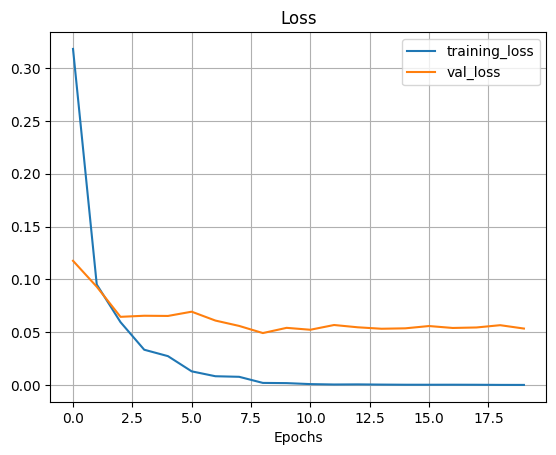

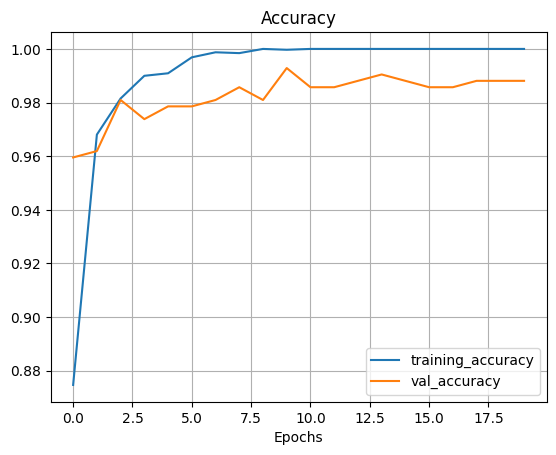

In [31]:
# Visualization of the training and validation loss (and accuracy)
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss 
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()

    # Plot accuracy 
    plt.figure()
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

In [32]:
# Evaluating the classification model's predictions on test

CLASSES = ['Monkeypox_augmented', 'Others_augmented']

# Predict labels for the test dataset using the trained model
pred_labels = model.predict(test_data)

# Function to round off softmax predictions to binary labels (0s and 1s)
# This converts the softmax output into one-hot encoding:
# - The index with the maximum value is set to 1
# - All other values are set to 0
def roundoff(arr):
    """Rounds off the predicted probabilities to binary (one-hot encoded) values."""
    arr[np.argwhere(arr != arr.max())] = 0 
    arr[np.argwhere(arr == arr.max())] = 1 
    return arr

# Apply the roundoff function to each predicted label array
for labels in pred_labels:
    labels = roundoff(labels)

# Print the classification report, which includes precision, recall, and F1-score
# 'target_names' maps the predicted and actual labels to the class names
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step
                     precision    recall  f1-score   support

Monkeypox_augmented       0.94      1.00      0.97        33
   Others_augmented       1.00      0.96      0.98        50

          micro avg       0.98      0.98      0.98        83
          macro avg       0.97      0.98      0.98        83
       weighted avg       0.98      0.98      0.98        83
        samples avg       0.98      0.98      0.98        83



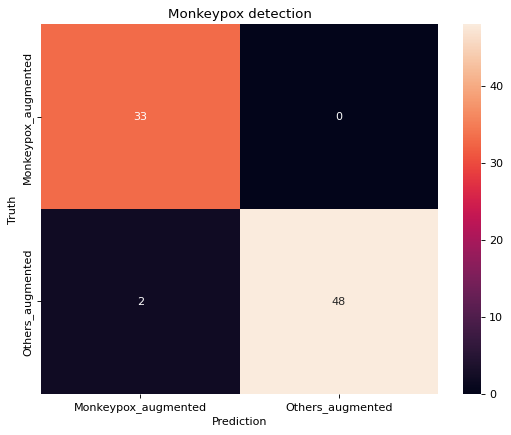

In [34]:
# Confusion Matrix
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

# cmap = sns.color_palette(["#945c23", "#fec59b"], as_cmap=True)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Monkeypox detection')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


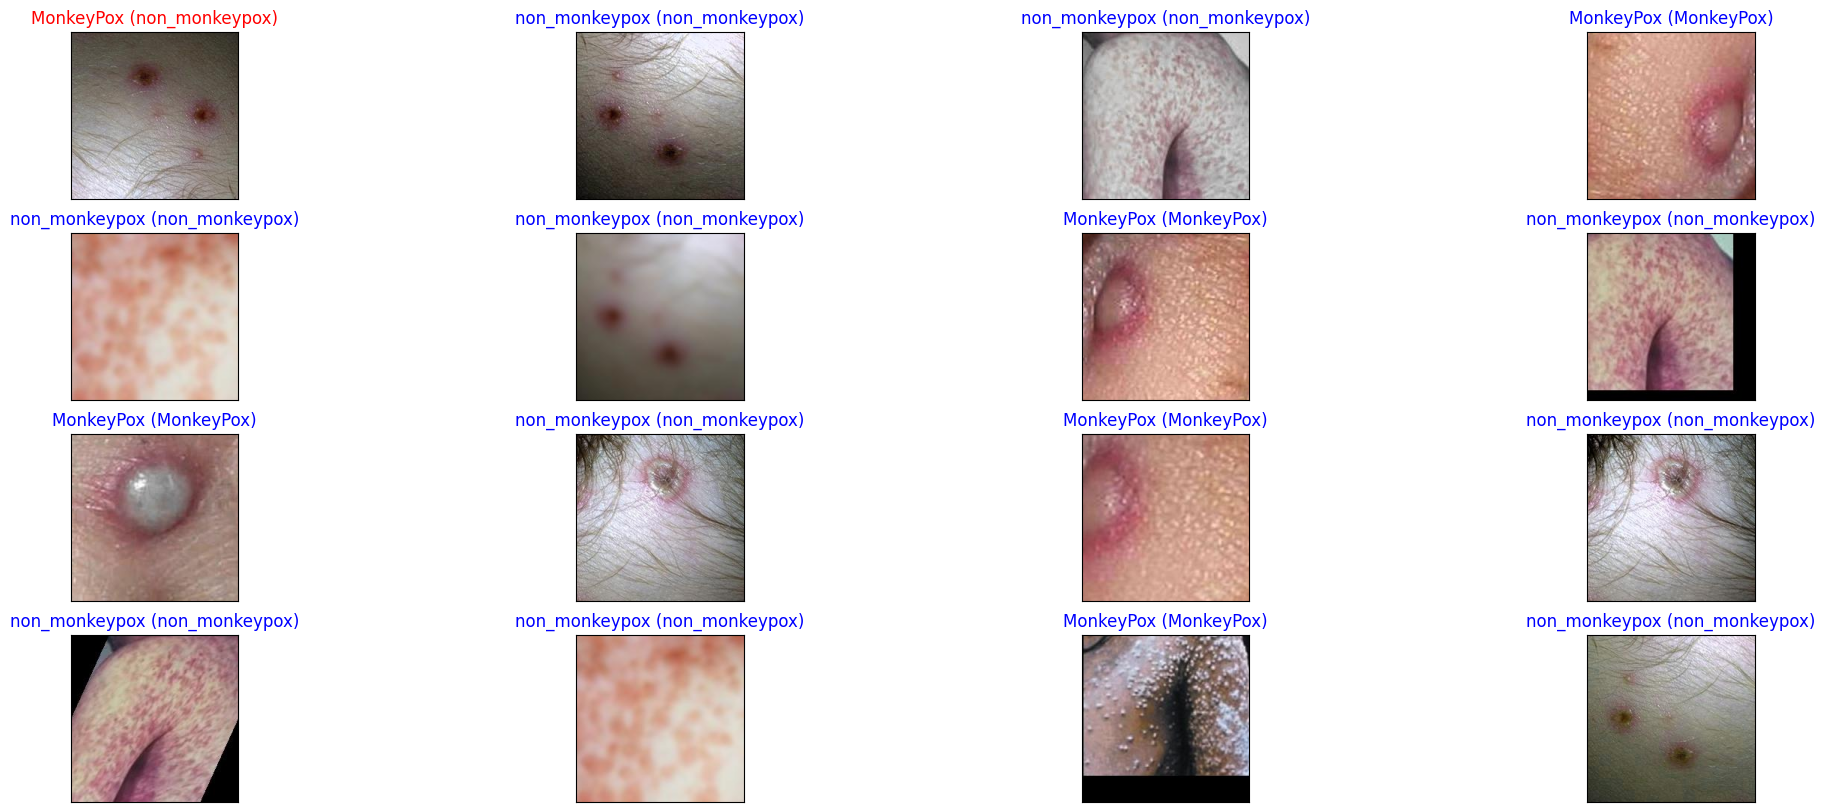

In [35]:
# Evaluate the predictions made by the classification model

y_hat = model.predict(test_data)

# define text labels
m_labels = ['MonkeyPox','non_monkeypox']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(25, 10))
for i, idx in enumerate(np.random.choice(test_data.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_data[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(test_labels[idx])
    ax.set_title("{} ({})".format(m_labels[pred_idx], m_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [36]:
model.save('DEPI_MONKEYPOX_MODEL.h5')

In [70]:
import shutil
shutil.move('monkeypox_model.h5', '/kaggle/working/monkeypox_model.h5')

'/kaggle/working/monkeypox_model.h5'

In [37]:
import plotly.io as pio
pio.renderers.default = 'iframe'  # Try 'iframe' or 'notebook_connected'

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
test_pred = model.predict(test_data)
test_pred_labels = np.argmax(test_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Evaluate model
test_scores = model.evaluate(test_data, test_labels, verbose=0)
test_accuracy = test_scores[1]
test_loss = test_scores[0]
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Classification Report
class_names = ['Monkeypox', 'Non-Monkeypox']
report = classification_report(test_true_labels, test_pred_labels, target_names=class_names, output_dict=True)
print("\nClassification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))

# ROC Curve and AUC
test_pred_proba = test_pred[:, 1]  # Probability for positive class (Non-Monkeypox)
fpr, tpr, _ = roc_curve(test_true_labels, test_pred_proba)
auc_score = roc_auc_score(test_true_labels, test_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Test Accuracy: 97.59%
Test Loss: 0.1533

Classification Report:
               precision    recall  f1-score   support

    Monkeypox       0.94      1.00      0.97        33
Non-Monkeypox       1.00      0.96      0.98        50

     accuracy                           0.98        83
    macro avg       0.97      0.98      0.98        83
 weighted avg       0.98      0.98      0.98        83

AUC Score: 0.9939


In [40]:
# Plotly: ROC Curve
fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {auc_score:.4f})', line=dict(color='blue')))
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(color='gray', dash='dash')))
fig_roc.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True,
    xaxis_range=[0, 1],
    yaxis_range=[0, 1]
)
fig_roc.show(renderer='iframe')

In [41]:
# Plotly: Accuracy and Loss
fig_acc_loss = go.Figure()
fig_acc_loss.add_trace(go.Bar(x=['Accuracy'], y=[test_accuracy], name='Accuracy', marker_color='blue'))
fig_acc_loss.add_trace(go.Bar(x=['Loss'], y=[test_loss], name='Loss', marker_color='red'))
fig_acc_loss.update_layout(
    title='Test Accuracy and Loss',
    xaxis_title='Metric',
    yaxis_title='Value',
    barmode='group'
)
fig_acc_loss.show(renderer='iframe')

In [43]:
# Plotly: Classification Report
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': [report[name]['precision'] for name in class_names],
    'Recall': [report[name]['recall'] for name in class_names],
    'F1-Score': [report[name]['f1-score'] for name in class_names]
})

fig_metrics = go.Figure()
fig_metrics.add_trace(go.Bar(x=class_names, y=metrics_df['Precision'], name='Precision'))
fig_metrics.add_trace(go.Bar(x=class_names, y=metrics_df['Recall'], name='Recall'))
fig_metrics.add_trace(go.Bar(x=class_names, y=metrics_df['F1-Score'], name='F1-Score'))
fig_metrics.update_layout(
    title='Classification Metrics',
    xaxis_title='Class',
    yaxis_title='Score',
    barmode='group',
    yaxis_range=[0, 1]
)
fig_metrics.show(renderer='iframe')